# Training a Matrix Product State

In this very simple example, we will train a Matrix Product State in an unsupervised setting, on a simplified $8\times 8$ version of the MNIST data set of handwritten digits. In this folder you will find a `requirements.txt` file, with which you can install all necessary dependencies to run the code via:
```
pip install -r requirements.txt
```
**Note**: This installs jax without support for any GPU/TPU accelerator. If you want to leverage those, follow the instructions [here](https://docs.jax.dev/en/latest/installation.html).

In [1]:
import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
import numpy as np
import opt_einsum as oe

from ml_collections import config_dict
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

from tn_utils.batch import batches
from tn_utils.labels import Labels

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
SEED = 42

COLORS = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00']

We use [ml_collections](https://ml-collections.readthedocs.io/en/latest/), a lightweight library for dict-like objects, to store all configuration for the MPS and the training. This makes passing these things around easy. You might as well use a `@dataclass`, `NamedTuple` or a plain old python dictonary, if you like.

In [3]:
cfg = config_dict.ConfigDict()
cfg.bond_dim = 2       # Initial dimensionality of the bonds between MPS tensors
cfg.phys_dim = 2       # Physical bond dimension
cfg.max_bond = 20      # Maximum bond dimension to truncate to
cfg.sigma_min = 0.05   # Minimum singular value threshold to truncate at
cfg.lrate = 0.01       # Learning rate
cfg.batch_size = 128   # Size of a batch
cfg.n_sweeps = 5       # Number of training sweeps (right -> left -> right)

Pseudo-random number generation in `jax` works very differently from e.g., `numpy`. Random numbers are generated with a random key, in a reproducible, parallelizable and vectorizable way. Generating the same amount of random numbers from the same key, will always yield the same result, hence we have to "split" the key into multiple new key later. To learn about the details, read [here](https://docs.jax.dev/en/latest/random-numbers.html#pseudorandom-numbers).

We initialize a key with the provided random seed.

In [4]:
rnd_key = jax.random.key(SEED)

## Loading and preparing data

The data set we are going to use, comes as an example data set with sckit-learn. We have:

* $8\times 8$ images of handwritten images in 10 classes (we won't use the labels here)
* 1797 images in total
* Each feature is an integer between 0 and 16, encoding a gray-scale value

We load the data set and convert it to bitstrings, such that every pixel either takes the value $0$ or $1$ first:

In [5]:
x, _ = load_digits(return_X_y=True)
n_sites = x.shape[1]

x = (x > 8).astype(np.uint8)

Let's have a look at some:

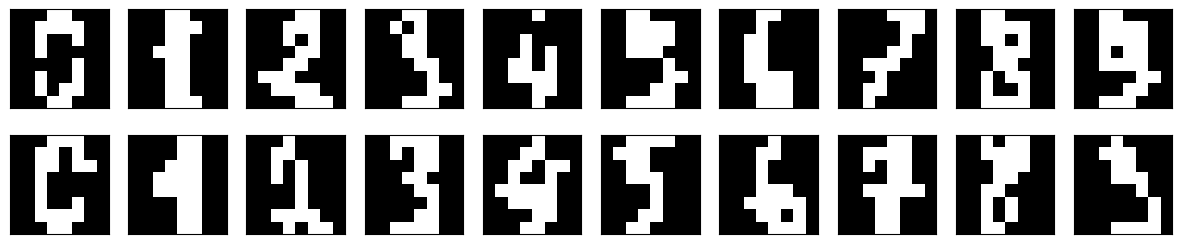

In [6]:
fig, ax = plt.subplots(2, 10, figsize=(15, 3))

for a, img in zip(ax.ravel(), x[:20]):
    a.set_xticks([])
    a.set_yticks([])
    a.set_aspect('equal')
    a.imshow(img.reshape((8,8)), cmap='gist_gray')


Now, in order to use classical data with an MPS, we have to encode it into a quantum state, such that for each sample $\boldsymbol{x}$ we have a state:

\begin{equation}
    |\boldsymbol{x}\rangle = |x_1\rangle \otimes |x_2\rangle \otimes\cdots\otimes|x_n\rangle.
\end{equation}

Here we use a simple encoding into the standard/computational basis, converting:

\begin{align}
    0 &\mapsto |0\rangle \\
    1 &\mapsto |1\rangle
\end{align}

We apply the `@jax.vmap` decorator twice to the function `basis_encode()` to vectorize it over both axis of our dataset (the first being the samples, the second the features). The function itself operates on a single feature. You can learn more about vectorization in `jax` [here](https://docs.jax.dev/en/latest/automatic-vectorization.html).

In [7]:
@jax.vmap
@jax.vmap
def basis_encode(x: int) -> jax.Array:
    return jnp.eye(2)[x]

In [8]:
x = basis_encode(x)

Finally we plit the dataset into a training set and a test set, with an 80/20 ratio:

In [9]:
x_train, x_test = train_test_split(x, test_size=0.2, shuffle=True)

## Initializing an MPS

We first initialize a random MPS with 64 sites:

In [10]:
rnd_key, *subkeys = jax.random.split(rnd_key, n_sites + 1)
bond_dims = [cfg.bond_dim] * (n_sites - 1) + [1]

mps = [
    jax.random.uniform(sk, (bond_dims[k-1], cfg.phys_dim, bond_dims[k]), minval=-1.0, maxval=1.0)
    for k, sk in enumerate(subkeys)
]

### Helper functions

There are certain operations, we have to do quite often, to keep the code readable and more succint, we wrap those into some helper functions here. The first is the singular value decomposition of a contracted tensor $C$:

\begin{equation}
    C = U\Sigma V^\dagger
\end{equation}

Which we can visually represent as:

<img src="img/svd.png" width=800px>

In [11]:
def svd(contracted: jax.Array) -> tuple[jax.Array, jax.Array, jax.Array]:
    lbond, lpbond, rpbond, rbond = contracted.shape

    u, s, v = jnp.linalg.svd(contracted.reshape((lbond * lpbond, rpbond * rbond)), full_matrices=False)
    return u, s, v

The second takes $U$ and $\Sigma$ truncates them to `bond` by discarding all but the first `bond` singular values and computes:

\begin{equation}
    r = \frac{U\Sigma}{\|U\Sigma\|}
\end{equation}

The renormalization ensures, the MPS has unit norm at all times.

In [12]:
def us(u: jax.Array, s: jax.Array, bond: int) -> jax.Array:
    result = u[:, :bond] @ jnp.diag(s[:bond])
    return result / jnp.linalg.norm(result)

Similar we have a helper for truncating and computing:

\begin{equation}
    r = \frac{\Sigma V^\dagger}{\|\Sigma V^\dagger\|}
\end{equation}

In [13]:
def sv(s: jax.Array, v: jax.Array, bond: int) -> jax.Array:
    result = jnp.diag(s[:bond]) @ v[:bond, :]
    return result / jnp.linalg.norm(result)

Finally a helper to compute how many singular values we keep after truncation. The function computes how many singular values are larger than the desired threshold and keeps at most as many as the specified maximum bond dimension.

In [14]:
def truncate_bond(s: jax.Array, cfg: config_dict.ConfigDict) -> int:
    _s = jnp.where(s >= cfg.sigma_min, s, 0.0)
    return jnp.maximum(jnp.minimum(jnp.count_nonzero(_s), cfg.max_bond), 2)

### Canonicalization

Before we start the training, we bring the MPS into _left canonical_ form, that is for all but the right most site we have:

<img src="img/lc.png" width=250px>

We achieve this, by sweeping from left to right and in each step:

* Contract the neighbouring sites
* Perform a singular value decomposition
* Replace the left site with $U$ and the right with $\Sigma V^\dagger$, while controlling trunctation and normalization.

In [15]:
for lidx in range(n_sites - 1):
    ridx = lidx + 1

    contracted = jnp.einsum('abc,cde->abde', mps[lidx], mps[ridx])
    lbond, lpbond, rpbond, rbond = contracted.shape

    u, s, v = svd(contracted)
    bond = truncate_bond(s, cfg)

    mps[lidx] = u[:, :bond].reshape((lbond, lpbond, bond))
    mps[ridx] = sv(s, v, bond).reshape((bond, rpbond, rbond))

## Training

Time to train. Firs we define the negative log-likelihood loss function:

\begin{equation}
    \mathcal{L} = -\frac{1}{|\mathcal{D}|}\sum_{\boldsymbol{x}\in\mathcal{D}}\log \frac{|\Psi(\boldsymbol{x})|^2}{Z}.
\end{equation}

Where $Z$ is the partition function $Z=\sum_{\boldsymbol{x}\in\mathcal{D}}|\Psi(\boldsymbol{x})|$ normalizing the probabilities to sum to 1. Since we maintain unit norm for our MPS at all times, we have $Z=1$.

In [16]:
def nll(mps: list[jax.Array], labels: Labels, x: jax.Array, cfg: config_dict.ConfigDict) -> float:    
    psi_expr = oe.contract_expression(
        labels.psi_einsum_str(),
        *[t.shape for t in mps],
        *[(cfg.phys_dim,)] * len(mps),
    )

    @jax.vmap
    def loss_fn(sample: jax.Array) -> jax.Array:
        return psi_expr(*mps, *sample)

    psi_values = loss_fn(x)

    return jnp.squeeze(-np.log(np.square(np.abs(psi_values))).mean(axis=0))

The `labels` object maintains all the bond labels and construct einsum strings for the contractions we need. You can find its implementation in `tn_utils/labels.py`:

In [17]:
labels = Labels(n_sites)

### Gradient computation

In the class below, we leverage several concepts to cumpute the gradient of the loss function with respect to a contracted tensor $C$. First, the gradient is given by:

\begin{equation}
    \nabla_C \mathcal{L} = \frac{\nabla_C Z}{Z} - \frac{2}{|\mathcal{D}|}\sum_{\boldsymbol{x}\in\mathcal{D}}
        \frac{\nabla_C \Psi(\boldsymbol{x})}{\Psi(\boldsymbol{x})}.
\end{equation}

The _data independent_ part, which we handle in the training loop, is simply (assuming unit norm):

\begin{equation}
    \frac{\nabla_C Z}{Z} = 2C.
\end{equation}

The class below computes the _data dependent part_:

\begin{equation}
    \frac{1}{|\mathcal{D}|}\sum_{\boldsymbol{x}\in\mathcal{D}}
        \frac{\nabla_C \Psi(\boldsymbol{x})}{\Psi(\boldsymbol{x})}.
\end{equation}

To do so, we'd normally have to perform two contractions of the MPS with each data sample, one for the value of $\Psi(\boldsymbol{x})$ and one for its gradient. Instead, we will use automatic differentiation for the latter. In detail:

* `_psic()` computes $\Psi(\boldsymbol{x})$ for a given sample $\boldsymbol{x}$ with one bond of the MPS currently being contracted.
* `_grad()` uses `jax.value_and_grad()` to call `_psi()` and compute its value and gradient with respect to `C`, returning $\frac{\nabla_C \Psi(\boldsymbol{x})}{\Psi(\boldsymbol{x})}$
* `__call__()` uses `jax.vmap()` to vectorize calls to `_grad()` over a batch of samples and returns the mean across that batch.

Furthermore, the class pre computes the optimal contraction path for this computation with `opt_einsum` in its constructor, since the shape of all tensors involved does not change while we train several batches.

In [18]:
class PsiGradient:
    def __init__(
        self, 
        mps: list[jax.Array], 
        labels: Labels,
        cbond: tuple[int, int],
        cshape: tuple[int, int, int, int],
        cfg: config_dict.ConfigDict
    ) -> None:
        self.mps = mps
        self.cbond = cbond
        lidx, ridx = cbond
        
        tshapes = [t.shape for t in mps[:lidx]]
        tshapes += [cshape]
        tshapes += [t.shape for t in mps[ridx+1:]]
        
        self.psic_expr = oe.contract_expression(
            labels.psic_einsum_str(cbond),
            *tshapes,
            *[(cfg.phys_dim,)] * len(mps)
        )
        
    def __call__(self, x: jax.Array, contracted: jax.Array) -> jax.Array:
        return jax.vmap(self._grad, in_axes=(0, None))(x, contracted).mean(axis=0)

    def _grad(self, sample: jax.Array, contracted: jax.Array) -> jax.Array:
        psi, psig = jax.value_and_grad(self._psic)(contracted, sample)
        return psig / psi

    def _psic(self, contracted: jax.Array, sample: jax.Array) -> jax.Array:
        lidx, ridx = self.cbond
        
        return jnp.squeeze(self.psic_expr(
            *self.mps[:lidx], contracted, *self.mps[ridx+1:], *sample
        ))

### Training loop

Before we finally get to the training loop, let's compute the initial negative log-likelihood loss of the MPS:

In [19]:
train_losses = [nll(mps, labels, x_train, cfg)]
test_losses = [nll(mps, labels, x_test, cfg)]
print(f"Initial loss, training data: {train_losses[-1]:.4f}")
print(f"Initial loss, test data: {test_losses[-1]:.4f}")

Initial loss, training data: 63.3618
Initial loss, test data: 62.8993


The training loop is fairly simple (and intentionally kept so) we perform several sweeps over the MPS, each sweep going from right to left and back to right, in each step, we do the following:

* Contract the current MPS site with its neighbour
* Train the contracted tensor on several mini-batches of data, using stochastic gradient descent
* Decompose the contracted tensor using SVD, truncate the bond dimension
* Update the tensors that contributed in the contraction with the SVD outcome
* Move to the next tensor

<img src="img/learning.png" width=700px>

In [20]:
for sweep in range(cfg.n_sweeps):
    print(f"Starting sweep {sweep + 1}")
    print("Sweep right to left...")

    for ridx in range(n_sites - 1, 0, -1):
        lidx = ridx - 1
        
        contracted = jnp.einsum('abc,cde->abde', mps[lidx], mps[ridx])
        lbond, lpbond, rpbond, rbond = contracted.shape
        psi_grad = PsiGradient(mps, labels, (lidx, ridx), contracted.shape, cfg)

        for batch in batches(x_train, cfg.batch_size):
            gradient = 2*(contracted - psi_grad(batch, contracted))
            contracted -= cfg.lrate * gradient

        u, s, v = svd(contracted)
        bond = truncate_bond(s, cfg)

        mps[lidx] = us(u, s, bond).reshape((lbond, lpbond, bond))
        mps[ridx] = v[:bond, :].reshape((bond, rpbond, rbond))
    
    print("Sweep left to right...")
    
    for lidx in range(n_sites - 1):
        ridx = lidx + 1
        
        contracted = jnp.einsum('abc,cde->abde', mps[lidx], mps[ridx])
        lbond, lpbond, rpbond, rbond = contracted.shape
        psi_grad = PsiGradient(mps, labels, (lidx, ridx), contracted.shape, cfg)
    
        for batch in batches(x_train, cfg.batch_size):
            gradient = 2*(contracted - psi_grad(batch, contracted))
            contracted -= cfg.lrate * gradient
    
        u, s, v = svd(contracted)
        bond = truncate_bond(s, cfg)
    
        mps[lidx] = u[:, :bond].reshape((lbond, lpbond, bond))
        mps[ridx] = sv(s, v, bond).reshape((bond, rpbond, rbond))

    train_losses.append(nll(mps, labels, x_train, cfg))
    test_losses.append(nll(mps, labels, x_test, cfg))
    print(f"Loss after sweep {sweep + 1}, test: {test_losses[-1]:.4f}, train: {train_losses[-1]:.4f}")


Starting sweep 1
Sweep right to left...
Sweep left to right...
Loss after sweep 1, test: 24.2907, train: 24.2350
Starting sweep 2
Sweep right to left...
Sweep left to right...
Loss after sweep 2, test: 24.8459, train: 24.4816
Starting sweep 3
Sweep right to left...
Sweep left to right...
Loss after sweep 3, test: 22.4184, train: 21.8632
Starting sweep 4
Sweep right to left...
Sweep left to right...
Loss after sweep 4, test: 22.2402, train: 21.4766
Starting sweep 5
Sweep right to left...
Sweep left to right...
Loss after sweep 5, test: 21.7702, train: 21.1961


### Evaluation

Get the size of the bonds between the MPS sites:

In [23]:
bond_dims = [t.shape[-1] for t in mps]

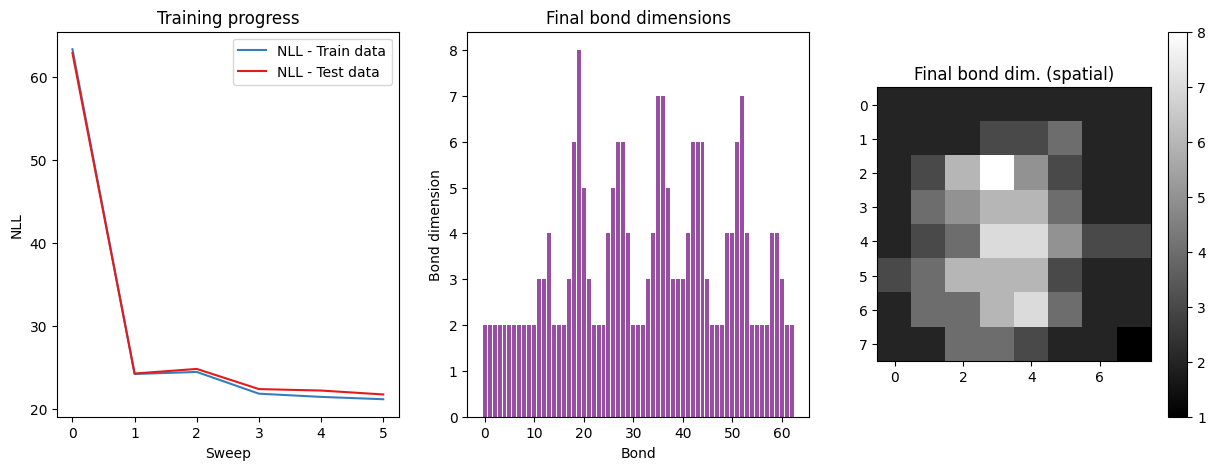

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].set_xlabel("Sweep")
ax[0].set_ylabel("NLL")
ax[0].set_title("Training progress")
ax[0].plot(range(cfg.n_sweeps + 1), train_losses, c=COLORS[1], label="NLL - Train data")
ax[0].plot(range(cfg.n_sweeps + 1), test_losses, c=COLORS[0], label="NLL - Test data")
ax[0].legend()

ax[1].set_xlabel("Bond")
ax[1].set_ylabel("Bond dimension")
ax[1].set_title("Final bond dimensions")
ax[1].bar(range(n_sites - 1), bond_dims[:-1], color=COLORS[3])

ax[2].set_title("Final bond dim. (spatial)")
imbond = ax[2].imshow(np.array(bond_dims).reshape((8,8)), cmap='gist_gray')

plt.colorbar(imbond)

### Sampling from the MPS

From the MPS in left-canonical form, we start sampling from the $N$-th site with probability:

\begin{equation*}
    P(x_{N}) = |\boldsymbol{v}^{x_{N}}|^{2},
\end{equation*}
with
\begin{equation*}
    \boldsymbol{v}^{x_{N}} = A^{(N)x_{N}}
\end{equation*}

Given the bits $x_{k},x_{k+1},\ldots,x_{N}$, the bit $x_{k-1}$ can be sampled by:

\begin{equation*}
    P(x_{k-1}|x_{k},x_{k+1},\ldots,x_{N})
        = \frac{P(x_{k-1},x_{k},x_{k+1}\ldots,x_{N})}{P(x_{k},x_{k+1},\ldots,x_{N})},
\end{equation*}

with the marginal distribution

\begin{equation*}
    P(x_{k}, x_{k+1}, \ldots, x_{N}) = |\boldsymbol{v}^{x_{k}x_{k+1}\ldots x_{N}}|^{2}
\end{equation*}

and

\begin{equation*}
    \boldsymbol{v}^{x_{k}x_{k+1}\ldots x_{N}} =
        \sum_{\alpha_{k}, \alpha_{k+1},\ldots, \alpha_{N-1}}
            A^{(k)x_{k}}_{\alpha_{k-1}\alpha_{k}}A^{(k+1)x_{k+1}}_{\alpha_{k}\alpha_{k+1}}
            \cdots
            A^{(N)x_{N}}_{\alpha_{N-1}}.
\end{equation*}

<img src="img/sample.png" width=500px>

In [37]:
def sample(
    mps: list[jax.typing.ArrayLike], 
    rng: np.random.Generator, 
    n_samples: int = 1
) -> np.ndarray:
    n_sites = len(mps)
    
    rand = rng.uniform(size=(n_samples, n_sites))
    out = np.empty(shape=(n_samples, n_sites), dtype=np.uint8)
    x = np.array([1.0])

    for sample in range(n_samples):
        for idx in reversed(range(n_sites)):
            xa = np.matmul(mps[idx][:, 1, :], x)
            sq_norm = (np.linalg.norm(xa) / np.linalg.norm(x)) ** 2

            if rand[sample, idx] < sq_norm:
                out[sample, idx] = 1
                x = xa
            else:
                out[sample, idx] = 0
                x = np.matmul(mps[idx][:, 0, :], x)

    return out

In [38]:
rng = np.random.default_rng(SEED)
samples = sample(mps, rng, n_samples=20)

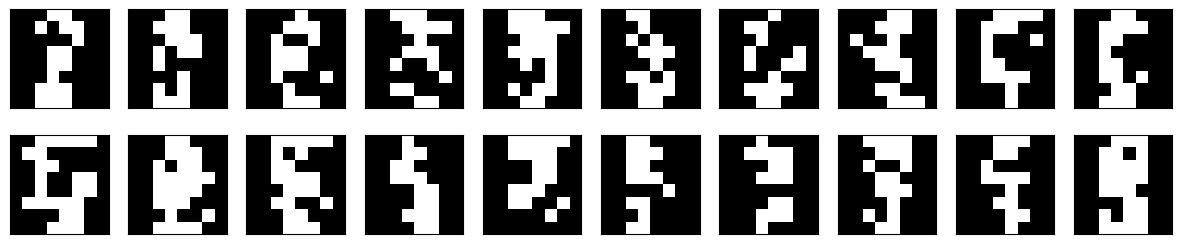

In [39]:
fig, ax = plt.subplots(2, 10, figsize=(15, 3))

for a, img in zip(ax.ravel(), samples):
    a.set_xticks([])
    a.set_yticks([])
    a.set_aspect('equal')
    a.imshow(img.reshape((8,8)), cmap='gist_gray')